In [1]:
import json
from pathlib import Path

import matplotlib.pyplot as plt
import pandas as pd
import pyprojroot
import seaborn as sns

In [2]:
def convert_seg_error_rate_pct(df):
    df.avg_segment_error_rate = df.avg_segment_error_rate * 100
    return df

In [3]:
HVC_RESULTS_ROOT = pyprojroot.here() / 'results/Bengalese_Finches/hvc'
source_csv = HVC_RESULTS_ROOT / 'segment_error_across_birds.hvc.csv'

In [4]:
hvc_df = pd.read_csv(source_csv)
# make hvc csv column names match the tweetynet column names
hvc_df.rename(
     columns={
         'mean_segment_error_rate': 'avg_segment_error_rate',
         'train_dur': 'train_set_dur',
         'replicate': 'replicate_num',
              },
    inplace=True)

hvc_df['Segmentation'] = hvc_df['source'].map({'ground_truth': 'Manually cleaned', 'resegment': 'Raw'})
hvc_df['Model'] = 'SVM'

In [5]:
LEARNCURVE_RESULTS_ROOT = pyprojroot.here() / 'results' / 'Bengalese_Finches' / 'learncurve'
error_csv_path = LEARNCURVE_RESULTS_ROOT.joinpath('error_across_birds_with_cleanup.csv')
curve_df = pd.read_csv(error_csv_path)

curve_df = curve_df[curve_df.animal_id.isin(hvc_df.animal_id.unique())]
curve_df['Model'] = 'TweetyNet'
curve_df['Segmentation'] = 'None'

In [6]:
CLEANUP = 'min_segment_dur_majority_vote'

curve_df = curve_df[
    curve_df.cleanup == CLEANUP
]

In [7]:
all_df = pd.concat([hvc_df, curve_df])

train_set_durs = sorted(all_df['train_set_dur'].unique())
dur_int_map = dict(zip(train_set_durs, range(len(train_set_durs))))
all_df['train_set_dur_ind'] = all_df['train_set_dur'].map(dur_int_map)

TRAIN_DUR_IND_MAP = {
k:v for k, v in zip(
    sorted(all_df['train_set_dur'].unique()), 
    sorted(all_df['train_set_dur_ind'].unique())
)
}

all_df = convert_seg_error_rate_pct(all_df)

In [8]:
all_df  # sanity check

,animal_id,train_set_dur,replicate_num,source,avg_segment_error_rate,Segmentation,Model,cleanup,avg_acc,avg_levenshtein,avg_pct_boundary_err,model_name,avg_error,train_set_dur_ind
0,bl26lb16,75,1,ground_truth,3.021246,Manually cleaned,SVM,NaN,NaN,NaN,NaN,NaN,NaN,2
1,bl26lb16,75,1,resegment,96.161960,Raw,SVM,NaN,NaN,NaN,NaN,NaN,NaN,2
2,bl26lb16,75,2,ground_truth,2.841600,Manually cleaned,SVM,NaN,NaN,NaN,NaN,NaN,NaN,2
3,bl26lb16,75,2,resegment,109.508609,Raw,SVM,NaN,NaN,NaN,NaN,NaN,NaN,2
4,bl26lb16,75,3,ground_truth,2.766980,Manually cleaned,SVM,NaN,NaN,NaN,NaN,NaN,NaN,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2222,or60yw70,45,6,NaN,2.346490,None,TweetyNet,min_segment_dur_majority_vote,0.976835,1.59375,0.719113,TweetyNet,2.316513,1
2226,or60yw70,45,7,NaN,2.843207,None,TweetyNet,min_segment_dur_majority_vote,0.977711,1.93750,0.709828,TweetyNet,2.228889,1
2230,or60yw70,45,8,NaN,4.238627,None,TweetyNet,min_segment_dur_majority_vote,0.969762,2.43750,0.613408,TweetyNet,3.023795,1
2234,or60yw70,45,9,NaN,2.622161,None,TweetyNet,min_segment_dur_majority_vote,0.977558,1.21875,0.730111,TweetyNet,2.244217,1


In [9]:
gb = all_df.groupby(by=['Model', 'Segmentation', 'animal_id', 'train_set_dur_ind'])
df_agg = gb.agg(
    mean_seg_err = pd.NamedAgg('avg_segment_error_rate', 'mean'),
    std_seg_err = pd.NamedAgg('avg_segment_error_rate', 'std')
)

data = df_agg.reset_index()  # ``data`` DataFrame for use with ``seaborn``

In [10]:
FIG_ROOT = pyprojroot.here() / 'doc' / 'article' / 'figures' / 'mainfig_tweetynet_v_svm'
FIG_ROOT.mkdir(exist_ok=True)

In [11]:
MODEL_HUE_MAP = {
    'SVM': 'blue',
    'TweetyNet': 'lawngreen',
}

In [13]:
svm_mean_seg_err_max_dur = data[
    (data.Model=='SVM') & (data.Segmentation == 'Manually cleaned') & (data.train_set_dur_ind ==  6)
].mean_seg_err.mean()

tweetynet_mean_seg_err_max_dur = data[
    (data.Model=='TweetyNet') & (data.Segmentation == 'None') & (data.train_set_dur_ind ==  6)
].mean_seg_err.mean()

<ipython-input-15-b6af322dd055>:44: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(train_set_durs, rotation=45)
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent 

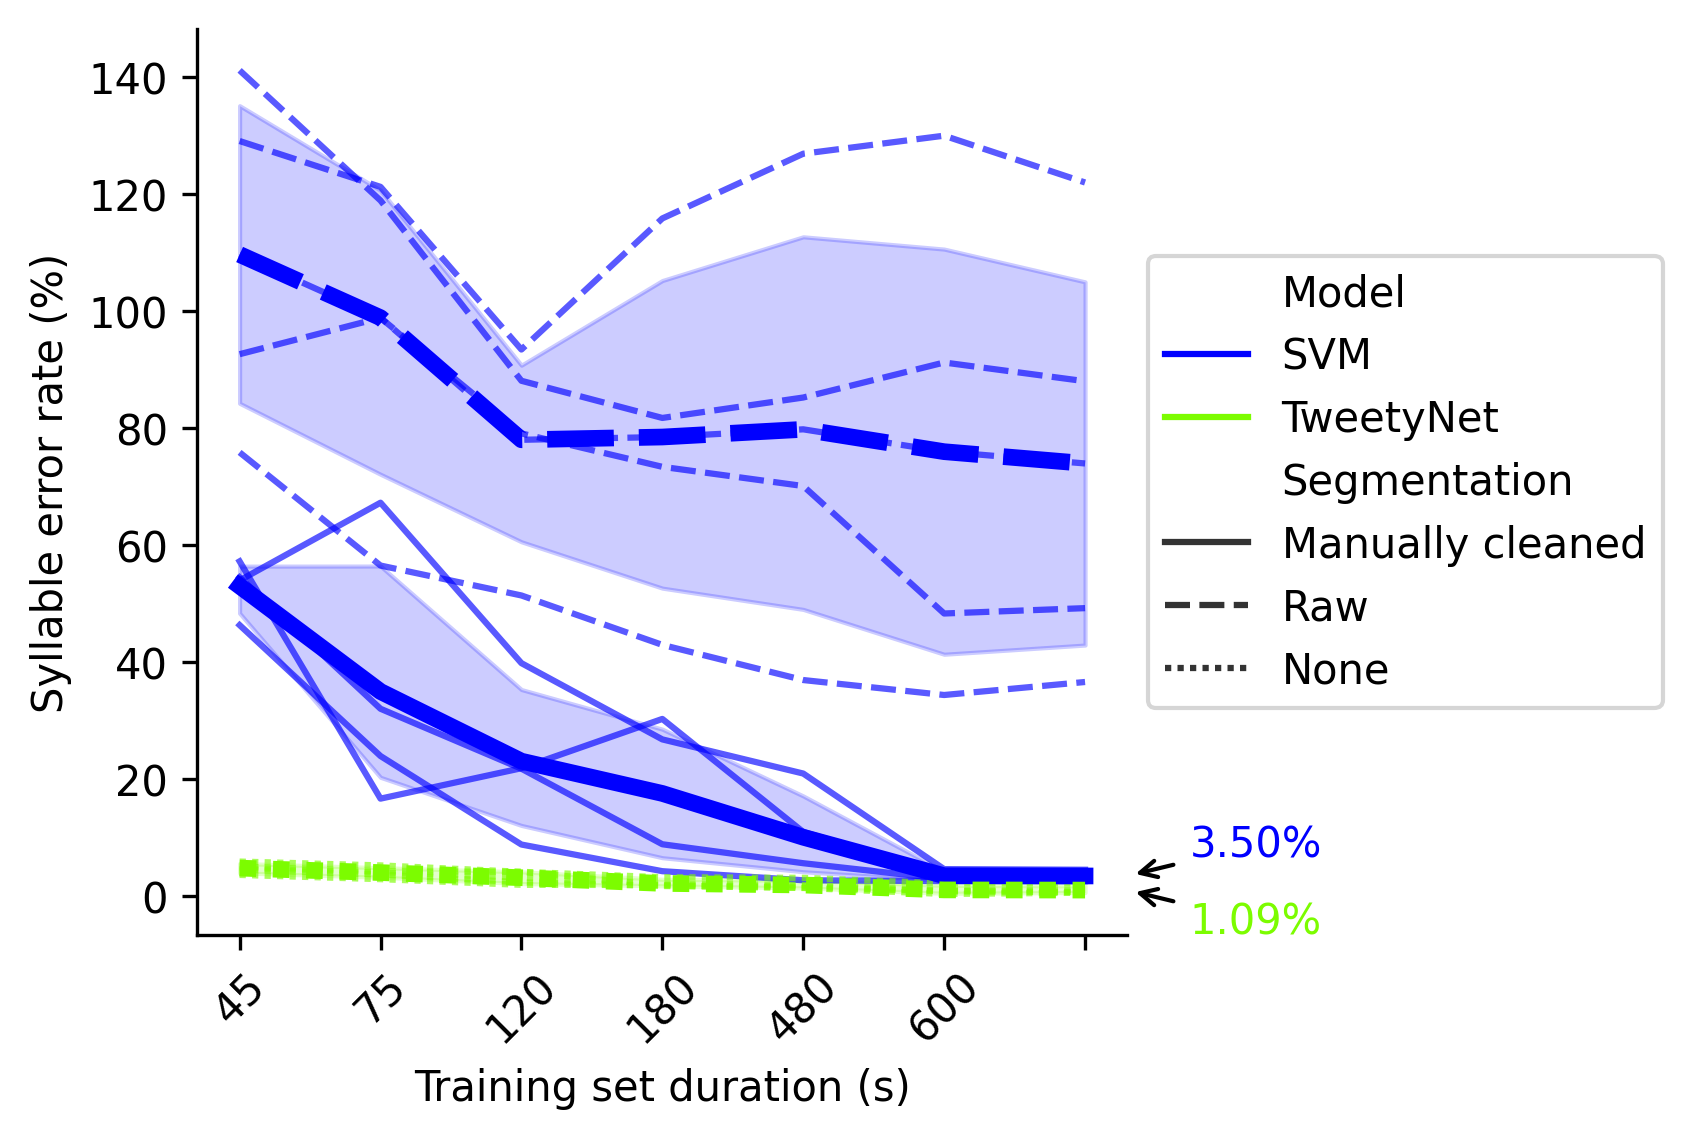

In [15]:
fig, ax = plt.subplots()
fig.set_dpi(300)
fig.set_size_inches(4,4)

sns.lineplot(
    data=data,
    x='train_set_dur_ind',
    y='mean_seg_err',
    hue='Model',
    palette=MODEL_HUE_MAP,
    style='Segmentation',
    units='animal_id',
    estimator=None,
    alpha=0.65,
    ax=ax,
    legend=False,
)


sns.lineplot(
    data=data,
    x='train_set_dur_ind',
    y='mean_seg_err',
    hue='Model',
    palette=MODEL_HUE_MAP,
    style='Segmentation',
    alpha=0.65,
    ax=ax,
    legend=True,
)

g = sns.lineplot(x='train_set_dur_ind',
             y='mean_seg_err',
             linewidth=4,
             style='Segmentation',
             hue='Model',
             palette=MODEL_HUE_MAP,
             data=data, 
             ci=None,
             ax=ax,
             legend=False)
g.legend(loc='center left', bbox_to_anchor=[1.0, 0.5])

ax.set_xticklabels(train_set_durs, rotation=45)

ax.annotate(f'{svm_mean_seg_err_max_dur:0.2f}%',
            xy=(ax.get_xlim()[-1], svm_mean_seg_err_max_dur), 
            xycoords='data',
            xytext=(15, +7.5),
            textcoords='offset points',
            verticalalignment='center',
            color=MODEL_HUE_MAP['SVM'],
            arrowprops=dict(arrowstyle="->", facecolor=MODEL_HUE_MAP['SVM']),
            annotation_clip=False)

ax.annotate(f'{tweetynet_mean_seg_err_max_dur:0.2f}%',
            xy=(ax.get_xlim()[-1], tweetynet_mean_seg_err_max_dur), 
            xycoords='data',
            xytext=(15, -7.5),
            textcoords='offset points',
            verticalalignment='center',
            color=MODEL_HUE_MAP['TweetyNet'],
            arrowprops=dict(arrowstyle="->", facecolor=MODEL_HUE_MAP['TweetyNet']),
            annotation_clip=False)

ax.set_xlabel('Training set duration (s)')
ax.set_ylabel('Syllable error rate (%)')

ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

FIG_STEM = 'svm-v-tweetynet-results'
    
for ext in ('eps', 'svg'):
    fig.savefig(FIG_ROOT / f'{FIG_STEM}.{ext}');